In [96]:
# Machine Learning Homework 3 -- Question 1
# Dominic Ridley

In [104]:
import scipy.io as spio
import matplotlib.pyplot as plt
import sys
import warnings
import math
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import normalize
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
from math import log
import numpy as np
from numpy import isneginf
np.seterr(divide='ignore')
import scipy
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical
import mnist

In [98]:
dtrain_data = spio.loadmat('d_train.mat')['data']
dtrain_labels = spio.loadmat('d_train.mat')['labels']

dtest_data = spio.loadmat('d_test.mat')['data']
dtest_labels = spio.loadmat('d_test.mat')['labels']

dtrain500_data = spio.loadmat('d_train500.mat')['data']
dtrain500_labels = spio.loadmat('d_train500.mat')['labels']

dtrain1k_data = spio.loadmat('d_train1000.mat')['data']
dtrain1k_labels = spio.loadmat('d_train1000.mat')['labels']

dtrain10k_data = spio.loadmat('d_train10000.mat')['data']
dtrain10k_labels = spio.loadmat('d_train10000.mat')['labels']

In [106]:
def tenFoldCrossVal(data, labels):
    
    
    #Attach labels to data
    dtrain = np.concatenate((data.T, labels.T), axis=1)
    x_size = len(dtrain)
    
    #Shuffle the data
    np.random.shuffle(dtrain)
    
    #Split the data in 10 batches
    sizeBatches = 10
    batches = np.split(dtrain, sizeBatches)
    
    cost_matrix = np.zeros((6,2))
    #accuracy_matrix = np.zeros((6,2))
    full_a_matrix = []
    
   
    for test_idx, test_batch in enumerate( batches ):

        #training_set = batches[test_idx]
        #test_set = np.delete(batches, test_idx, 0)

        test_set = batches[test_idx]
        training_set = np.delete(batches, test_idx, 0)
        training_set = np.concatenate(training_set)
        
        train_data = training_set[:, :2]
        train_labels = training_set[:, 2:]

        test_data =  test_set[:, :2]
        test_labels = test_set[:, 2:]
        
        
        accuracy_matrix = np.zeros((6,2))
        
        #Some Preprocessing, Scale data between 0 and 1
        mscaler = MinMaxScaler()
        train_data = mscaler.fit_transform(train_data)
        test_data = mscaler.fit_transform(test_data)
        #train_data = normalize(train_data)
        #test_data = normalize(test_data)

        plt.figure()
        
        #test_labels = test_labels
        # print(test_labels)
        for i, xy in enumerate(train_data):
            if train_labels[i] == 1:
                plt.plot(xy[0], xy[1],'b.')
            if train_labels[i] == 2:
                plt.plot(xy[0], xy[1],'r.')
            if train_labels[i] == 3:
                plt.plot(xy[0], xy[1],'g.')

        plt.show()
    
        train_labels = train_labels - np.ones_like(train_labels)
        train_labels = to_categorical(train_labels, num_classes=3)
        
        test_labels = test_labels - np.ones_like(test_labels)
        test_labels = to_categorical(test_labels, num_classes=3)

        nClasses = 3
        hm_epochs = 100
        adam_o = keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, amsgrad=False)
        sgd_o = keras.optimizers.SGD(learning_rate=0.0001, momentum=0.0, nesterov=False)
        rU = keras.initializers.RandomUniform(minval=-3, maxval=3, seed=0)
        xavier = keras.initializers.glorot_normal(seed=None)
        he = keras.initializers.he_normal(seed=None)
        
        for numPerceptrons in range(4, 7):
            for af in range(2):
                t_cost = 0
                
                model = Sequential()
                if af == 0:
                    model.add(Dense(numPerceptrons, input_dim=2, activation='elu', 
                                    kernel_initializer= xavier,
                                    bias_initializer='zeros'))
                if af == 1:
                    model.add(Dense(numPerceptrons, input_dim=2, activation='sigmoid',
                                    kernel_initializer = he,
                                    bias_initializer='zeros'))
                    
                model.add(Dense(3, activation='softmax',
                                    kernel_initializer= xavier,
                                    bias_initializer='zeros'))
                model.compile(loss='categorical_crossentropy', optimizer=sgd_o, \
                                 metrics=['accuracy'])
                
                model.summary()
                
                #Fit Model
                history = model.fit(train_data, train_labels, 
                                    epochs=hm_epochs, 
                                    verbose=1)
                
        
                #model.evaluate(train_data, train_labels)
                
                
                #Test Model
                y_hat = model.predict(test_data)
                y_hat = np.array([np.argmax(y_hat, axis=1)])
                y_pred = to_categorical(y_hat.T, num_classes=3)
                a = accuracy_score(test_labels, y_pred)
                accuracy_matrix[numPerceptrons-1, af] = a
                print(a)
                
        full_a_matrix.append(accuracy_matrix)

    full_a_matrix = np.array(full_a_matrix)
    full_a_matrix = np.mean(full_a_matrix, axis = 0)

    print(full_a_matrix)
    e_pair = np.unravel_index(np.argmax(full_a_matrix, axis=None), \
                                    full_a_matrix.shape)
    
    e_pair = tuple([e_pair[0] + 1, e_pair[1]])
    print(e_pair)
    return y_hat

n_error = True
while(n_error):
    try:
        n, e_pair = tenFoldCrossVal(dtrain_data, dtrain_labels)
        nPerceptrons = e_pair[0]
        af = e_pair[1]
        test_score, test_labels = n.fit_model(dtest_data.T, dtest_labels.T, af, nPerceptrons)
        print(test_score)
        plt.figure()
        
        test_labels = test_labels.T
        for i, xy in enumerate(dtest_data.T):
            if test_labels[i] == 1:
                plt.plot(xy[0], xy[1],'b.')
            if test_labels[i] == 2:
                plt.plot(xy[0], xy[1],'r.')
            if test_labels[i] == 3:
                plt.plot(xy[0], xy[1],'g.')
                
        plt.show()
        
        n_error = False
    #except ValueError as ve:
    #    print(ve)
    #    print('\nReinitializing')
    except ZeroDivisionError:
        print('Reinitializing')
    except RuntimeError:
        print('Reinitializing')


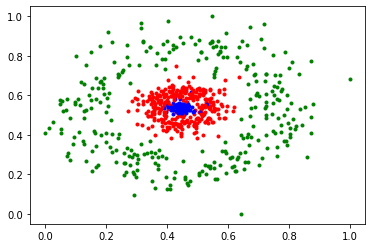

Model: "sequential_48"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_95 (Dense)             (None, 4)                 12        
_________________________________________________________________
dense_96 (Dense)             (None, 3)                 15        
Total params: 27
Trainable params: 27
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
900/900 [==============================] - 0s 516us/step - loss: 1.1967 - accuracy: 0.3367
Epoch 2/100
900/900 [==============================] - 0s 97us/step - loss: 1.1962 - accuracy: 0.3367
Epoch 3/100
900/900 [==============================] - 0s 227us/step - loss: 1.1956 - accuracy: 0.3367
Epoch 4/100
900/900 [==============================] - 0s 158us/step - loss: 1.1951 - accuracy: 0.3367
Epoch 5/100
900/900 [==============================] - 0s 202us/step - loss: 1.1946 - accuracy: 0.3367
Epoch

900/900 [==============================] - 0s 202us/step - loss: 1.1654 - accuracy: 0.3367
Epoch 74/100
900/900 [==============================] - 0s 216us/step - loss: 1.1651 - accuracy: 0.3367
Epoch 75/100
900/900 [==============================] - 0s 197us/step - loss: 1.1648 - accuracy: 0.3367
Epoch 76/100
900/900 [==============================] - 0s 152us/step - loss: 1.1644 - accuracy: 0.3367
Epoch 77/100
900/900 [==============================] - 0s 115us/step - loss: 1.1641 - accuracy: 0.3367
Epoch 78/100
900/900 [==============================] - 0s 123us/step - loss: 1.1638 - accuracy: 0.3367
Epoch 79/100
900/900 [==============================] - 0s 110us/step - loss: 1.1634 - accuracy: 0.3367
Epoch 80/100
900/900 [==============================] - 0s 149us/step - loss: 1.1631 - accuracy: 0.3367
Epoch 81/100
900/900 [==============================] - 0s 149us/step - loss: 1.1628 - accuracy: 0.3367
Epoch 82/100
900/900 [==============================] - 0s 139us/step - loss:

900/900 [==============================] - 0s 253us/step - loss: 1.1403 - accuracy: 0.31890s - loss: 1.1406 - accuracy: 0.31
Epoch 47/100
900/900 [==============================] - 0s 270us/step - loss: 1.1402 - accuracy: 0.3189
Epoch 48/100
900/900 [==============================] - 0s 100us/step - loss: 1.1401 - accuracy: 0.3189
Epoch 49/100
900/900 [==============================] - 0s 169us/step - loss: 1.1400 - accuracy: 0.3189
Epoch 50/100
900/900 [==============================] - 0s 154us/step - loss: 1.1399 - accuracy: 0.3189
Epoch 51/100
900/900 [==============================] - 0s 280us/step - loss: 1.1397 - accuracy: 0.3189
Epoch 52/100
900/900 [==============================] - 0s 150us/step - loss: 1.1396 - accuracy: 0.3189
Epoch 53/100
900/900 [==============================] - 0s 250us/step - loss: 1.1395 - accuracy: 0.3189
Epoch 54/100
900/900 [==============================] - 0s 177us/step - loss: 1.1394 - accuracy: 0.3189
Epoch 55/100
900/900 [=====================

900/900 [==============================] - 0s 120us/step - loss: 1.1107 - accuracy: 0.3567
Epoch 19/100
900/900 [==============================] - 0s 107us/step - loss: 1.1106 - accuracy: 0.3567
Epoch 20/100
900/900 [==============================] - 0s 132us/step - loss: 1.1105 - accuracy: 0.3556
Epoch 21/100
900/900 [==============================] - 0s 199us/step - loss: 1.1104 - accuracy: 0.3556
Epoch 22/100
900/900 [==============================] - 0s 216us/step - loss: 1.1103 - accuracy: 0.3556
Epoch 23/100
900/900 [==============================] - 0s 186us/step - loss: 1.1103 - accuracy: 0.3567
Epoch 24/100
900/900 [==============================] - 0s 170us/step - loss: 1.1102 - accuracy: 0.3556
Epoch 25/100
900/900 [==============================] - 0s 86us/step - loss: 1.1101 - accuracy: 0.3556
Epoch 26/100
900/900 [==============================] - 0s 87us/step - loss: 1.1100 - accuracy: 0.3556
Epoch 27/100
900/900 [==============================] - 0s 182us/step - loss: 1

900/900 [==============================] - 0s 172us/step - loss: 1.1053 - accuracy: 0.3789
Epoch 97/100
900/900 [==============================] - 0s 110us/step - loss: 1.1052 - accuracy: 0.3789
Epoch 98/100
900/900 [==============================] - 0s 144us/step - loss: 1.1052 - accuracy: 0.3789
Epoch 99/100
900/900 [==============================] - 0s 152us/step - loss: 1.1051 - accuracy: 0.3789
Epoch 100/100
900/900 [==============================] - 0s 114us/step - loss: 1.1050 - accuracy: 0.3800
0.28
Model: "sequential_51"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_101 (Dense)            (None, 5)                 15        
_________________________________________________________________
dense_102 (Dense)            (None, 3)                 18        
Total params: 33
Trainable params: 33
Non-trainable params: 0
_________________________________________________________________
Epoch 

900/900 [==============================] - 0s 162us/step - loss: 1.1117 - accuracy: 0.3189
Epoch 70/100
900/900 [==============================] - 0s 140us/step - loss: 1.1116 - accuracy: 0.3189
Epoch 71/100
900/900 [==============================] - 0s 167us/step - loss: 1.1115 - accuracy: 0.3189
Epoch 72/100
900/900 [==============================] - 0s 125us/step - loss: 1.1114 - accuracy: 0.3189
Epoch 73/100
900/900 [==============================] - 0s 203us/step - loss: 1.1113 - accuracy: 0.3189
Epoch 74/100
900/900 [==============================] - 0s 148us/step - loss: 1.1113 - accuracy: 0.3189
Epoch 75/100
900/900 [==============================] - 0s 128us/step - loss: 1.1112 - accuracy: 0.3189
Epoch 76/100
900/900 [==============================] - 0s 124us/step - loss: 1.1111 - accuracy: 0.3189
Epoch 77/100
900/900 [==============================] - 0s 141us/step - loss: 1.1110 - accuracy: 0.3189
Epoch 78/100
900/900 [==============================] - 0s 196us/step - loss:

900/900 [==============================] - 0s 213us/step - loss: 1.1305 - accuracy: 0.3344
Epoch 43/100
900/900 [==============================] - 0s 153us/step - loss: 1.1303 - accuracy: 0.3344
Epoch 44/100
900/900 [==============================] - 0s 170us/step - loss: 1.1301 - accuracy: 0.3344
Epoch 45/100
900/900 [==============================] - 0s 154us/step - loss: 1.1299 - accuracy: 0.3344
Epoch 46/100
900/900 [==============================] - 0s 147us/step - loss: 1.1298 - accuracy: 0.3344
Epoch 47/100
900/900 [==============================] - 0s 97us/step - loss: 1.1296 - accuracy: 0.3344
Epoch 48/100
900/900 [==============================] - 0s 148us/step - loss: 1.1294 - accuracy: 0.3344
Epoch 49/100
900/900 [==============================] - 0s 235us/step - loss: 1.1292 - accuracy: 0.3344
Epoch 50/100
900/900 [==============================] - 0s 198us/step - loss: 1.1291 - accuracy: 0.3344
Epoch 51/100
900/900 [==============================] - 0s 170us/step - loss: 

900/900 [==============================] - 0s 170us/step - loss: 1.1098 - accuracy: 0.2278
Epoch 16/100
900/900 [==============================] - 0s 230us/step - loss: 1.1097 - accuracy: 0.2278
Epoch 17/100
900/900 [==============================] - 0s 155us/step - loss: 1.1097 - accuracy: 0.2278
Epoch 18/100
900/900 [==============================] - 0s 233us/step - loss: 1.1097 - accuracy: 0.2278
Epoch 19/100
900/900 [==============================] - 0s 181us/step - loss: 1.1096 - accuracy: 0.2278
Epoch 20/100
900/900 [==============================] - 0s 132us/step - loss: 1.1096 - accuracy: 0.2278
Epoch 21/100
900/900 [==============================] - 0s 167us/step - loss: 1.1095 - accuracy: 0.2267
Epoch 22/100
900/900 [==============================] - 0s 169us/step - loss: 1.1095 - accuracy: 0.2278
Epoch 23/100
900/900 [==============================] - 0s 141us/step - loss: 1.1094 - accuracy: 0.2267
Epoch 24/100
900/900 [==============================] - 0s 148us/step - loss:

900/900 [==============================] - 0s 154us/step - loss: 1.1066 - accuracy: 0.2322
Epoch 94/100
900/900 [==============================] - 0s 140us/step - loss: 1.1066 - accuracy: 0.2322
Epoch 95/100
900/900 [==============================] - 0s 139us/step - loss: 1.1066 - accuracy: 0.2322
Epoch 96/100
900/900 [==============================] - 0s 133us/step - loss: 1.1065 - accuracy: 0.2322
Epoch 97/100
900/900 [==============================] - 0s 149us/step - loss: 1.1065 - accuracy: 0.2322
Epoch 98/100
900/900 [==============================] - 0s 149us/step - loss: 1.1064 - accuracy: 0.2322
Epoch 99/100
900/900 [==============================] - 0s 120us/step - loss: 1.1064 - accuracy: 0.2322
Epoch 100/100
900/900 [==============================] - 0s 138us/step - loss: 1.1064 - accuracy: 0.2333
0.3


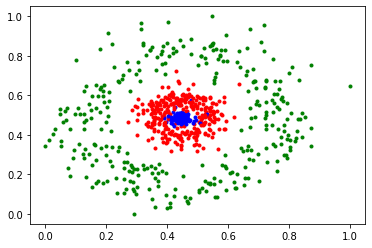

Model: "sequential_54"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_107 (Dense)            (None, 4)                 12        
_________________________________________________________________
dense_108 (Dense)            (None, 3)                 15        
Total params: 27
Trainable params: 27
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
900/900 [==============================] - 0s 424us/step - loss: 1.1269 - accuracy: 0.3267
Epoch 2/100
900/900 [==============================] - 0s 117us/step - loss: 1.1268 - accuracy: 0.3267
Epoch 3/100
900/900 [==============================] - 0s 134us/step - loss: 1.1266 - accuracy: 0.3267
Epoch 4/100
900/900 [==============================] - 0s 131us/step - loss: 1.1265 - accuracy: 0.3267
Epoch 5/100
900/900 [==============================] - 0s 168us/step - loss: 1.1263 - accuracy: 0.3267
Epoc

900/900 [==============================] - 0s 194us/step - loss: 1.1180 - accuracy: 0.3278
Epoch 74/100
900/900 [==============================] - 0s 151us/step - loss: 1.1179 - accuracy: 0.3278
Epoch 75/100
900/900 [==============================] - 0s 129us/step - loss: 1.1178 - accuracy: 0.3278
Epoch 76/100
900/900 [==============================] - 0s 211us/step - loss: 1.1177 - accuracy: 0.3278
Epoch 77/100
900/900 [==============================] - 0s 184us/step - loss: 1.1176 - accuracy: 0.3278
Epoch 78/100
900/900 [==============================] - 0s 154us/step - loss: 1.1175 - accuracy: 0.3278
Epoch 79/100
900/900 [==============================] - 0s 110us/step - loss: 1.1174 - accuracy: 0.3278
Epoch 80/100
900/900 [==============================] - 0s 136us/step - loss: 1.1173 - accuracy: 0.3278
Epoch 81/100
900/900 [==============================] - 0s 98us/step - loss: 1.1172 - accuracy: 0.3278
Epoch 82/100
900/900 [==============================] - 0s 96us/step - loss: 1

900/900 [==============================] - 0s 134us/step - loss: 1.1365 - accuracy: 0.3267
Epoch 47/100
900/900 [==============================] - 0s 106us/step - loss: 1.1363 - accuracy: 0.3267
Epoch 48/100
900/900 [==============================] - ETA: 0s - loss: 1.1384 - accuracy: 0.31 - 0s 99us/step - loss: 1.1362 - accuracy: 0.3267
Epoch 49/100
900/900 [==============================] - 0s 112us/step - loss: 1.1361 - accuracy: 0.3267
Epoch 50/100
900/900 [==============================] - 0s 130us/step - loss: 1.1360 - accuracy: 0.3267
Epoch 51/100
900/900 [==============================] - 0s 128us/step - loss: 1.1358 - accuracy: 0.3267
Epoch 52/100
900/900 [==============================] - 0s 151us/step - loss: 1.1357 - accuracy: 0.3267
Epoch 53/100
900/900 [==============================] - 0s 162us/step - loss: 1.1356 - accuracy: 0.3267
Epoch 54/100
900/900 [==============================] - 0s 176us/step - loss: 1.1355 - accuracy: 0.3267
Epoch 55/100
900/900 [==============

900/900 [==============================] - 0s 160us/step - loss: 1.1043 - accuracy: 0.4122
Epoch 18/100
900/900 [==============================] - 0s 141us/step - loss: 1.1043 - accuracy: 0.4122
Epoch 19/100
900/900 [==============================] - 0s 135us/step - loss: 1.1043 - accuracy: 0.4122
Epoch 20/100
900/900 [==============================] - 0s 138us/step - loss: 1.1042 - accuracy: 0.4122
Epoch 21/100
900/900 [==============================] - 0s 236us/step - loss: 1.1042 - accuracy: 0.4122
Epoch 22/100
900/900 [==============================] - 0s 111us/step - loss: 1.1041 - accuracy: 0.4122
Epoch 23/100
900/900 [==============================] - 0s 90us/step - loss: 1.1041 - accuracy: 0.4122
Epoch 24/100
900/900 [==============================] - 0s 137us/step - loss: 1.1040 - accuracy: 0.4122
Epoch 25/100
900/900 [==============================] - 0s 196us/step - loss: 1.1040 - accuracy: 0.4133
Epoch 26/100
900/900 [==============================] - 0s 163us/step - loss: 

Epoch 96/100
900/900 [==============================] - 0s 146us/step - loss: 1.1014 - accuracy: 0.4344
Epoch 97/100
900/900 [==============================] - 0s 168us/step - loss: 1.1013 - accuracy: 0.4344
Epoch 98/100
900/900 [==============================] - 0s 183us/step - loss: 1.1013 - accuracy: 0.4344
Epoch 99/100
900/900 [==============================] - 0s 187us/step - loss: 1.1013 - accuracy: 0.4344
Epoch 100/100
900/900 [==============================] - 0s 145us/step - loss: 1.1012 - accuracy: 0.4344
0.53
Model: "sequential_57"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_113 (Dense)            (None, 5)                 15        
_________________________________________________________________
dense_114 (Dense)            (None, 3)                 18        
Total params: 33
Trainable params: 33
Non-trainable params: 0
___________________________________________________________

900/900 [==============================] - ETA: 0s - loss: 1.2541 - accuracy: 0.33 - 0s 164us/step - loss: 1.2571 - accuracy: 0.3278
Epoch 69/100
900/900 [==============================] - 0s 132us/step - loss: 1.2561 - accuracy: 0.3278
Epoch 70/100
900/900 [==============================] - 0s 143us/step - loss: 1.2552 - accuracy: 0.3278
Epoch 71/100
900/900 [==============================] - 0s 169us/step - loss: 1.2543 - accuracy: 0.3278
Epoch 72/100
900/900 [==============================] - 0s 148us/step - loss: 1.2534 - accuracy: 0.3278
Epoch 73/100
900/900 [==============================] - 0s 130us/step - loss: 1.2525 - accuracy: 0.3278
Epoch 74/100
900/900 [==============================] - 0s 124us/step - loss: 1.2515 - accuracy: 0.3278
Epoch 75/100
900/900 [==============================] - 0s 101us/step - loss: 1.2507 - accuracy: 0.3278
Epoch 76/100
900/900 [==============================] - 0s 145us/step - loss: 1.2498 - accuracy: 0.3278
Epoch 77/100
900/900 [=============

900/900 [==============================] - 0s 206us/step - loss: 1.1219 - accuracy: 0.1922
Epoch 41/100
900/900 [==============================] - 0s 178us/step - loss: 1.1217 - accuracy: 0.1922
Epoch 42/100
900/900 [==============================] - 0s 116us/step - loss: 1.1216 - accuracy: 0.1900
Epoch 43/100
900/900 [==============================] - 0s 114us/step - loss: 1.1214 - accuracy: 0.1900
Epoch 44/100
900/900 [==============================] - 0s 141us/step - loss: 1.1213 - accuracy: 0.1900
Epoch 45/100
900/900 [==============================] - 0s 120us/step - loss: 1.1211 - accuracy: 0.1900
Epoch 46/100
900/900 [==============================] - 0s 114us/step - loss: 1.1210 - accuracy: 0.1900
Epoch 47/100
900/900 [==============================] - 0s 113us/step - loss: 1.1208 - accuracy: 0.1900
Epoch 48/100
900/900 [==============================] - 0s 105us/step - loss: 1.1207 - accuracy: 0.1911
Epoch 49/100
900/900 [==============================] - 0s 102us/step - loss:

900/900 [==============================] - 0s 146us/step - loss: 1.1866 - accuracy: 0.3278
Epoch 13/100
900/900 [==============================] - 0s 174us/step - loss: 1.1861 - accuracy: 0.3278
Epoch 14/100
900/900 [==============================] - 0s 170us/step - loss: 1.1857 - accuracy: 0.3278
Epoch 15/100
900/900 [==============================] - 0s 163us/step - loss: 1.1853 - accuracy: 0.3278
Epoch 16/100
900/900 [==============================] - 0s 199us/step - loss: 1.1849 - accuracy: 0.3278
Epoch 17/100
900/900 [==============================] - 0s 242us/step - loss: 1.1845 - accuracy: 0.3278
Epoch 18/100
900/900 [==============================] - 0s 206us/step - loss: 1.1840 - accuracy: 0.3278
Epoch 19/100
900/900 [==============================] - 0s 160us/step - loss: 1.1837 - accuracy: 0.3278
Epoch 20/100
900/900 [==============================] - 0s 186us/step - loss: 1.1833 - accuracy: 0.3278
Epoch 21/100
900/900 [==============================] - 0s 217us/step - loss:

900/900 [==============================] - 0s 135us/step - loss: 1.1586 - accuracy: 0.3278
Epoch 91/100
900/900 [==============================] - 0s 115us/step - loss: 1.1583 - accuracy: 0.3278
Epoch 92/100
900/900 [==============================] - 0s 163us/step - loss: 1.1580 - accuracy: 0.3278
Epoch 93/100
900/900 [==============================] - 0s 129us/step - loss: 1.1577 - accuracy: 0.3278
Epoch 94/100
900/900 [==============================] - 0s 133us/step - loss: 1.1574 - accuracy: 0.3278
Epoch 95/100
900/900 [==============================] - 0s 149us/step - loss: 1.1571 - accuracy: 0.3278
Epoch 96/100
900/900 [==============================] - 0s 136us/step - loss: 1.1568 - accuracy: 0.3278
Epoch 97/100
900/900 [==============================] - 0s 163us/step - loss: 1.1565 - accuracy: 0.3278
Epoch 98/100
900/900 [==============================] - 0s 158us/step - loss: 1.1562 - accuracy: 0.3278
Epoch 99/100
900/900 [==============================] - 0s 158us/step - loss:

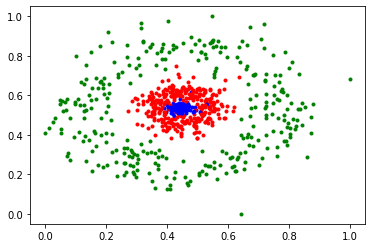

Model: "sequential_60"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_119 (Dense)            (None, 4)                 12        
_________________________________________________________________
dense_120 (Dense)            (None, 3)                 15        
Total params: 27
Trainable params: 27
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
900/900 [==============================] - 0s 489us/step - loss: 1.1154 - accuracy: 0.3389
Epoch 2/100
900/900 [==============================] - 0s 107us/step - loss: 1.1153 - accuracy: 0.3389
Epoch 3/100
900/900 [==============================] - 0s 117us/step - loss: 1.1153 - accuracy: 0.3389
Epoch 4/100
900/900 [==============================] - 0s 147us/step - loss: 1.1152 - accuracy: 0.3389
Epoch 5/100
900/900 [==============================] - 0s 139us/step - loss: 1.1152 - accuracy: 0.3389
Epoc

900/900 [==============================] - 0s 158us/step - loss: 1.1119 - accuracy: 0.3389
Epoch 74/100
900/900 [==============================] - 0s 115us/step - loss: 1.1118 - accuracy: 0.3389
Epoch 75/100
900/900 [==============================] - 0s 150us/step - loss: 1.1118 - accuracy: 0.3389
Epoch 76/100
900/900 [==============================] - 0s 158us/step - loss: 1.1117 - accuracy: 0.3389
Epoch 77/100
900/900 [==============================] - 0s 165us/step - loss: 1.1117 - accuracy: 0.3389
Epoch 78/100
900/900 [==============================] - 0s 172us/step - loss: 1.1117 - accuracy: 0.3389
Epoch 79/100
900/900 [==============================] - 0s 174us/step - loss: 1.1116 - accuracy: 0.3389
Epoch 80/100
900/900 [==============================] - 0s 163us/step - loss: 1.1116 - accuracy: 0.3389
Epoch 81/100
900/900 [==============================] - 0s 162us/step - loss: 1.1116 - accuracy: 0.3389
Epoch 82/100
900/900 [==============================] - 0s 115us/step - loss:

900/900 [==============================] - 0s 128us/step - loss: 1.1338 - accuracy: 0.3200
Epoch 46/100
900/900 [==============================] - 0s 125us/step - loss: 1.1337 - accuracy: 0.3200
Epoch 47/100
900/900 [==============================] - 0s 127us/step - loss: 1.1336 - accuracy: 0.3200
Epoch 48/100
900/900 [==============================] - 0s 239us/step - loss: 1.1335 - accuracy: 0.3200
Epoch 49/100
900/900 [==============================] - 0s 146us/step - loss: 1.1334 - accuracy: 0.3200
Epoch 50/100
900/900 [==============================] - 0s 110us/step - loss: 1.1333 - accuracy: 0.3200
Epoch 51/100
900/900 [==============================] - 0s 156us/step - loss: 1.1332 - accuracy: 0.3200
Epoch 52/100
900/900 [==============================] - 0s 140us/step - loss: 1.1331 - accuracy: 0.3200
Epoch 53/100
900/900 [==============================] - 0s 163us/step - loss: 1.1330 - accuracy: 0.3200
Epoch 54/100
900/900 [==============================] - 0s 131us/step - loss:

900/900 [==============================] - 0s 179us/step - loss: 1.1123 - accuracy: 0.3378
Epoch 19/100
900/900 [==============================] - 0s 123us/step - loss: 1.1122 - accuracy: 0.3378
Epoch 20/100
900/900 [==============================] - 0s 147us/step - loss: 1.1121 - accuracy: 0.3378
Epoch 21/100
900/900 [==============================] - 0s 122us/step - loss: 1.1121 - accuracy: 0.3378
Epoch 22/100
900/900 [==============================] - 0s 153us/step - loss: 1.1120 - accuracy: 0.3378
Epoch 23/100
900/900 [==============================] - 0s 195us/step - loss: 1.1119 - accuracy: 0.3378
Epoch 24/100
900/900 [==============================] - 0s 150us/step - loss: 1.1118 - accuracy: 0.3378
Epoch 25/100
900/900 [==============================] - 0s 218us/step - loss: 1.1118 - accuracy: 0.3378
Epoch 26/100
900/900 [==============================] - 0s 231us/step - loss: 1.1117 - accuracy: 0.3378
Epoch 27/100
900/900 [==============================] - 0s 146us/step - loss:

900/900 [==============================] - 0s 166us/step - loss: 1.1074 - accuracy: 0.3111
Epoch 97/100
900/900 [==============================] - 0s 74us/step - loss: 1.1074 - accuracy: 0.3100
Epoch 98/100
900/900 [==============================] - 0s 63us/step - loss: 1.1073 - accuracy: 0.3100
Epoch 99/100
900/900 [==============================] - 0s 185us/step - loss: 1.1073 - accuracy: 0.3100
Epoch 100/100
900/900 [==============================] - 0s 168us/step - loss: 1.1072 - accuracy: 0.3100
0.29
Model: "sequential_63"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_125 (Dense)            (None, 5)                 15        
_________________________________________________________________
dense_126 (Dense)            (None, 3)                 18        
Total params: 33
Trainable params: 33
Non-trainable params: 0
_________________________________________________________________
Epoch 1/

900/900 [==============================] - 0s 177us/step - loss: 1.1503 - accuracy: 0.3411
Epoch 69/100
900/900 [==============================] - 0s 174us/step - loss: 1.1501 - accuracy: 0.3411
Epoch 70/100
900/900 [==============================] - 0s 138us/step - loss: 1.1500 - accuracy: 0.3411
Epoch 71/100
900/900 [==============================] - 0s 109us/step - loss: 1.1498 - accuracy: 0.3411
Epoch 72/100
900/900 [==============================] - 0s 126us/step - loss: 1.1497 - accuracy: 0.3411
Epoch 73/100
900/900 [==============================] - 0s 158us/step - loss: 1.1495 - accuracy: 0.3411
Epoch 74/100
900/900 [==============================] - 0s 160us/step - loss: 1.1493 - accuracy: 0.3411
Epoch 75/100
900/900 [==============================] - 0s 173us/step - loss: 1.1492 - accuracy: 0.3411
Epoch 76/100
900/900 [==============================] - 0s 144us/step - loss: 1.1490 - accuracy: 0.3411
Epoch 77/100
900/900 [==============================] - 0s 157us/step - loss:

900/900 [==============================] - 0s 170us/step - loss: 1.1637 - accuracy: 0.3378
Epoch 42/100
900/900 [==============================] - 0s 176us/step - loss: 1.1633 - accuracy: 0.3378
Epoch 43/100
900/900 [==============================] - 0s 172us/step - loss: 1.1628 - accuracy: 0.3378
Epoch 44/100
900/900 [==============================] - 0s 153us/step - loss: 1.1623 - accuracy: 0.3378
Epoch 45/100
900/900 [==============================] - 0s 102us/step - loss: 1.1618 - accuracy: 0.3378
Epoch 46/100
900/900 [==============================] - 0s 225us/step - loss: 1.1613 - accuracy: 0.3378
Epoch 47/100
900/900 [==============================] - 0s 112us/step - loss: 1.1609 - accuracy: 0.3378
Epoch 48/100
900/900 [==============================] - 0s 158us/step - loss: 1.1604 - accuracy: 0.3378
Epoch 49/100
900/900 [==============================] - 0s 154us/step - loss: 1.1599 - accuracy: 0.3378
Epoch 50/100
900/900 [==============================] - 0s 142us/step - loss:

900/900 [==============================] - 0s 221us/step - loss: 1.2640 - accuracy: 0.3389
Epoch 14/100
900/900 [==============================] - 0s 130us/step - loss: 1.2631 - accuracy: 0.3389
Epoch 15/100
900/900 [==============================] - 0s 120us/step - loss: 1.2622 - accuracy: 0.3389
Epoch 16/100
900/900 [==============================] - 0s 101us/step - loss: 1.2612 - accuracy: 0.3389
Epoch 17/100
900/900 [==============================] - 0s 55us/step - loss: 1.2603 - accuracy: 0.3389
Epoch 18/100
900/900 [==============================] - 0s 147us/step - loss: 1.2593 - accuracy: 0.3389
Epoch 19/100
900/900 [==============================] - 0s 164us/step - loss: 1.2584 - accuracy: 0.3389
Epoch 20/100
900/900 [==============================] - 0s 167us/step - loss: 1.2575 - accuracy: 0.3389
Epoch 21/100
900/900 [==============================] - 0s 128us/step - loss: 1.2566 - accuracy: 0.3389
Epoch 22/100
900/900 [==============================] - 0s 161us/step - loss: 

900/900 [==============================] - 0s 128us/step - loss: 1.2039 - accuracy: 0.3389
Epoch 92/100
900/900 [==============================] - 0s 150us/step - loss: 1.2033 - accuracy: 0.3389
Epoch 93/100
900/900 [==============================] - 0s 197us/step - loss: 1.2027 - accuracy: 0.3389
Epoch 94/100
900/900 [==============================] - 0s 169us/step - loss: 1.2021 - accuracy: 0.3389
Epoch 95/100
900/900 [==============================] - 0s 164us/step - loss: 1.2015 - accuracy: 0.3389
Epoch 96/100
900/900 [==============================] - 0s 164us/step - loss: 1.2009 - accuracy: 0.3389
Epoch 97/100
900/900 [==============================] - 0s 114us/step - loss: 1.2003 - accuracy: 0.3389
Epoch 98/100
900/900 [==============================] - 0s 151us/step - loss: 1.1998 - accuracy: 0.3389
Epoch 99/100
900/900 [==============================] - 0s 173us/step - loss: 1.1992 - accuracy: 0.3389
Epoch 100/100
900/900 [==============================] - 0s 184us/step - loss

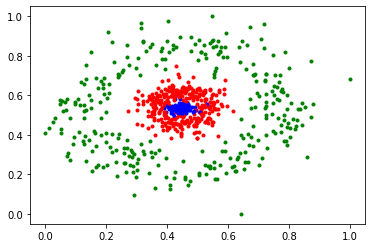

Model: "sequential_66"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_131 (Dense)            (None, 4)                 12        
_________________________________________________________________
dense_132 (Dense)            (None, 3)                 15        
Total params: 27
Trainable params: 27
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
900/900 [==============================] - 0s 535us/step - loss: 1.1501 - accuracy: 0.3300
Epoch 2/100
900/900 [==============================] - 0s 148us/step - loss: 1.1498 - accuracy: 0.3300
Epoch 3/100
900/900 [==============================] - 0s 209us/step - loss: 1.1495 - accuracy: 0.3300
Epoch 4/100
900/900 [==============================] - 0s 159us/step - loss: 1.1491 - accuracy: 0.3300
Epoch 5/100
900/900 [==============================] - 0s 173us/step - loss: 1.1488 - accuracy: 0.3300
Epoc

Epoch 74/100
900/900 [==============================] - 0s 151us/step - loss: 1.1321 - accuracy: 0.3311
Epoch 75/100
900/900 [==============================] - 0s 144us/step - loss: 1.1319 - accuracy: 0.3311
Epoch 76/100
900/900 [==============================] - 0s 231us/step - loss: 1.1317 - accuracy: 0.3311
Epoch 77/100
900/900 [==============================] - 0s 207us/step - loss: 1.1315 - accuracy: 0.3311
Epoch 78/100
900/900 [==============================] - 0s 215us/step - loss: 1.1313 - accuracy: 0.3311
Epoch 79/100
900/900 [==============================] - 0s 186us/step - loss: 1.1312 - accuracy: 0.3311
Epoch 80/100
900/900 [==============================] - 0s 203us/step - loss: 1.1310 - accuracy: 0.3311
Epoch 81/100
900/900 [==============================] - 0s 170us/step - loss: 1.1308 - accuracy: 0.3322
Epoch 82/100
900/900 [==============================] - 0s 139us/step - loss: 1.1306 - accuracy: 0.3322
Epoch 83/100
900/900 [==============================] - 0s 200us

900/900 [==============================] - 0s 288us/step - loss: 1.1927 - accuracy: 0.3322
Epoch 47/100
900/900 [==============================] - 0s 185us/step - loss: 1.1924 - accuracy: 0.3322
Epoch 48/100
900/900 [==============================] - 0s 190us/step - loss: 1.1921 - accuracy: 0.3322
Epoch 49/100
900/900 [==============================] - 0s 151us/step - loss: 1.1918 - accuracy: 0.3322
Epoch 50/100
900/900 [==============================] - 0s 205us/step - loss: 1.1915 - accuracy: 0.3322
Epoch 51/100
900/900 [==============================] - 0s 223us/step - loss: 1.1912 - accuracy: 0.3322
Epoch 52/100
900/900 [==============================] - 0s 158us/step - loss: 1.1909 - accuracy: 0.3322
Epoch 53/100
900/900 [==============================] - 0s 161us/step - loss: 1.1906 - accuracy: 0.3322
Epoch 54/100
900/900 [==============================] - 0s 154us/step - loss: 1.1903 - accuracy: 0.3322
Epoch 55/100
900/900 [==============================] - 0s 118us/step - loss:

900/900 [==============================] - 0s 149us/step - loss: 1.1209 - accuracy: 0.3378
Epoch 19/100
900/900 [==============================] - 0s 97us/step - loss: 1.1206 - accuracy: 0.3378
Epoch 20/100
900/900 [==============================] - 0s 99us/step - loss: 1.1204 - accuracy: 0.3378
Epoch 21/100
900/900 [==============================] - 0s 117us/step - loss: 1.1201 - accuracy: 0.3378
Epoch 22/100
900/900 [==============================] - 0s 115us/step - loss: 1.1198 - accuracy: 0.3378
Epoch 23/100
900/900 [==============================] - 0s 226us/step - loss: 1.1196 - accuracy: 0.3378
Epoch 24/100
900/900 [==============================] - 0s 156us/step - loss: 1.1194 - accuracy: 0.3378
Epoch 25/100
900/900 [==============================] - 0s 150us/step - loss: 1.1191 - accuracy: 0.3378
Epoch 26/100
900/900 [==============================] - 0s 140us/step - loss: 1.1189 - accuracy: 0.3378
Epoch 27/100
900/900 [==============================] - 0s 129us/step - loss: 1

900/900 [==============================] - 0s 161us/step - loss: 1.1069 - accuracy: 0.3378
Epoch 96/100
900/900 [==============================] - 0s 151us/step - loss: 1.1068 - accuracy: 0.3378
Epoch 97/100
900/900 [==============================] - 0s 134us/step - loss: 1.1067 - accuracy: 0.3378
Epoch 98/100
900/900 [==============================] - 0s 137us/step - loss: 1.1066 - accuracy: 0.3378
Epoch 99/100
900/900 [==============================] - 0s 145us/step - loss: 1.1065 - accuracy: 0.3378
Epoch 100/100
900/900 [==============================] - 0s 133us/step - loss: 1.1064 - accuracy: 0.3378
0.34
Model: "sequential_69"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_137 (Dense)            (None, 5)                 15        
_________________________________________________________________
dense_138 (Dense)            (None, 3)                 18        
Total params: 33
Trainable par

900/900 [==============================] - 0s 201us/step - loss: 1.1515 - accuracy: 0.3378
Epoch 68/100
900/900 [==============================] - 0s 191us/step - loss: 1.1513 - accuracy: 0.3378
Epoch 69/100
900/900 [==============================] - 0s 181us/step - loss: 1.1511 - accuracy: 0.3378
Epoch 70/100
900/900 [==============================] - 0s 173us/step - loss: 1.1509 - accuracy: 0.3378
Epoch 71/100
900/900 [==============================] - 0s 139us/step - loss: 1.1506 - accuracy: 0.3378
Epoch 72/100
900/900 [==============================] - 0s 156us/step - loss: 1.1504 - accuracy: 0.3378
Epoch 73/100
900/900 [==============================] - 0s 163us/step - loss: 1.1502 - accuracy: 0.3378
Epoch 74/100
900/900 [==============================] - 0s 173us/step - loss: 1.1500 - accuracy: 0.3378
Epoch 75/100
900/900 [==============================] - 0s 143us/step - loss: 1.1498 - accuracy: 0.3378
Epoch 76/100
900/900 [==============================] - 0s 233us/step - loss:

900/900 [==============================] - 0s 171us/step - loss: 1.1060 - accuracy: 0.4511
Epoch 41/100
900/900 [==============================] - 0s 96us/step - loss: 1.1059 - accuracy: 0.4511
Epoch 42/100
900/900 [==============================] - 0s 149us/step - loss: 1.1059 - accuracy: 0.4511
Epoch 43/100
900/900 [==============================] - 0s 154us/step - loss: 1.1058 - accuracy: 0.4511
Epoch 44/100
900/900 [==============================] - 0s 194us/step - loss: 1.1057 - accuracy: 0.45110s - loss: 1.1083 - accuracy: 0.
Epoch 45/100
900/900 [==============================] - 0s 148us/step - loss: 1.1057 - accuracy: 0.4511
Epoch 46/100
900/900 [==============================] - 0s 201us/step - loss: 1.1056 - accuracy: 0.4511
Epoch 47/100
900/900 [==============================] - 0s 149us/step - loss: 1.1055 - accuracy: 0.4511
Epoch 48/100
900/900 [==============================] - 0s 167us/step - loss: 1.1055 - accuracy: 0.4522
Epoch 49/100
900/900 [========================

900/900 [==============================] - 0s 206us/step - loss: 1.4483 - accuracy: 0.3322
Epoch 13/100
900/900 [==============================] - 0s 125us/step - loss: 1.4461 - accuracy: 0.3322
Epoch 14/100
900/900 [==============================] - 0s 113us/step - loss: 1.4438 - accuracy: 0.3322
Epoch 15/100
900/900 [==============================] - 0s 206us/step - loss: 1.4416 - accuracy: 0.3322
Epoch 16/100
900/900 [==============================] - 0s 188us/step - loss: 1.4394 - accuracy: 0.3322
Epoch 17/100
900/900 [==============================] - 0s 188us/step - loss: 1.4372 - accuracy: 0.3322
Epoch 18/100
900/900 [==============================] - 0s 237us/step - loss: 1.4351 - accuracy: 0.3322
Epoch 19/100
900/900 [==============================] - 0s 214us/step - loss: 1.4329 - accuracy: 0.3322
Epoch 20/100
900/900 [==============================] - 0s 218us/step - loss: 1.4308 - accuracy: 0.3322
Epoch 21/100
900/900 [==============================] - 0s 192us/step - loss:

900/900 [==============================] - 0s 92us/step - loss: 1.3072 - accuracy: 0.3322
Epoch 92/100
900/900 [==============================] - 0s 118us/step - loss: 1.3058 - accuracy: 0.3322
Epoch 93/100
900/900 [==============================] - 0s 94us/step - loss: 1.3044 - accuracy: 0.3322
Epoch 94/100
900/900 [==============================] - 0s 94us/step - loss: 1.3031 - accuracy: 0.3322
Epoch 95/100
900/900 [==============================] - 0s 89us/step - loss: 1.3017 - accuracy: 0.3322
Epoch 96/100
900/900 [==============================] - 0s 92us/step - loss: 1.3003 - accuracy: 0.3322
Epoch 97/100
900/900 [==============================] - 0s 107us/step - loss: 1.2990 - accuracy: 0.3322
Epoch 98/100
900/900 [==============================] - 0s 101us/step - loss: 1.2977 - accuracy: 0.3322
Epoch 99/100
900/900 [==============================] - 0s 94us/step - loss: 1.2963 - accuracy: 0.3322
Epoch 100/100
900/900 [==============================] - 0s 90us/step - loss: 1.295

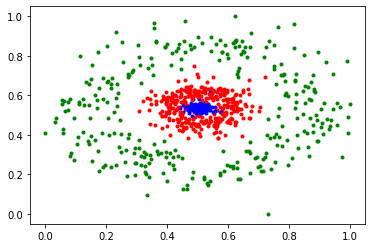

Model: "sequential_72"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_143 (Dense)            (None, 4)                 12        
_________________________________________________________________
dense_144 (Dense)            (None, 3)                 15        
Total params: 27
Trainable params: 27
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
900/900 [==============================] - 0s 318us/step - loss: 1.1042 - accuracy: 0.4200
Epoch 2/100
900/900 [==============================] - 0s 68us/step - loss: 1.1042 - accuracy: 0.4200
Epoch 3/100
900/900 [==============================] - 0s 105us/step - loss: 1.1042 - accuracy: 0.4200
Epoch 4/100
900/900 [==============================] - 0s 97us/step - loss: 1.1041 - accuracy: 0.4200
Epoch 5/100
900/900 [==============================] - 0s 77us/step - loss: 1.1041 - accuracy: 0.4200
Epoch 6

900/900 [==============================] - 0s 79us/step - loss: 1.1022 - accuracy: 0.4278
Epoch 75/100
900/900 [==============================] - 0s 99us/step - loss: 1.1022 - accuracy: 0.4278
Epoch 76/100
900/900 [==============================] - 0s 82us/step - loss: 1.1022 - accuracy: 0.4278
Epoch 77/100
900/900 [==============================] - 0s 78us/step - loss: 1.1022 - accuracy: 0.4278
Epoch 78/100
900/900 [==============================] - 0s 89us/step - loss: 1.1021 - accuracy: 0.4289
Epoch 79/100
900/900 [==============================] - 0s 79us/step - loss: 1.1021 - accuracy: 0.4289
Epoch 80/100
900/900 [==============================] - 0s 79us/step - loss: 1.1021 - accuracy: 0.4289
Epoch 81/100
900/900 [==============================] - 0s 78us/step - loss: 1.1021 - accuracy: 0.4289
Epoch 82/100
900/900 [==============================] - 0s 79us/step - loss: 1.1020 - accuracy: 0.4289
Epoch 83/100
900/900 [==============================] - 0s 78us/step - loss: 1.1020 - 

900/900 [==============================] - 0s 92us/step - loss: 1.1736 - accuracy: 0.3489
Epoch 48/100
900/900 [==============================] - 0s 104us/step - loss: 1.1733 - accuracy: 0.3489
Epoch 49/100
900/900 [==============================] - 0s 107us/step - loss: 1.1731 - accuracy: 0.3489
Epoch 50/100
900/900 [==============================] - 0s 108us/step - loss: 1.1728 - accuracy: 0.3489
Epoch 51/100
900/900 [==============================] - 0s 85us/step - loss: 1.1725 - accuracy: 0.3489
Epoch 52/100
900/900 [==============================] - 0s 90us/step - loss: 1.1722 - accuracy: 0.3489
Epoch 53/100
900/900 [==============================] - 0s 101us/step - loss: 1.1720 - accuracy: 0.3489
Epoch 54/100
900/900 [==============================] - 0s 105us/step - loss: 1.1717 - accuracy: 0.3489
Epoch 55/100
900/900 [==============================] - 0s 83us/step - loss: 1.1714 - accuracy: 0.3489
Epoch 56/100
900/900 [==============================] - 0s 78us/step - loss: 1.17

900/900 [==============================] - 0s 77us/step - loss: 1.1183 - accuracy: 0.4289
Epoch 21/100
900/900 [==============================] - 0s 72us/step - loss: 1.1183 - accuracy: 0.4300
Epoch 22/100
900/900 [==============================] - 0s 73us/step - loss: 1.1182 - accuracy: 0.4300
Epoch 23/100
900/900 [==============================] - 0s 106us/step - loss: 1.1181 - accuracy: 0.4311
Epoch 24/100
900/900 [==============================] - 0s 83us/step - loss: 1.1180 - accuracy: 0.4311
Epoch 25/100
900/900 [==============================] - 0s 73us/step - loss: 1.1179 - accuracy: 0.4322
Epoch 26/100
900/900 [==============================] - 0s 74us/step - loss: 1.1178 - accuracy: 0.4333
Epoch 27/100
900/900 [==============================] - 0s 75us/step - loss: 1.1177 - accuracy: 0.4333
Epoch 28/100
900/900 [==============================] - 0s 83us/step - loss: 1.1176 - accuracy: 0.4333
Epoch 29/100
900/900 [==============================] - 0s 88us/step - loss: 1.1175 -

900/900 [==============================] - 0s 110us/step - loss: 1.1127 - accuracy: 0.4478
Epoch 100/100
900/900 [==============================] - 0s 109us/step - loss: 1.1127 - accuracy: 0.4478
0.31
Model: "sequential_75"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_149 (Dense)            (None, 5)                 15        
_________________________________________________________________
dense_150 (Dense)            (None, 3)                 18        
Total params: 33
Trainable params: 33
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
900/900 [==============================] - 0s 363us/step - loss: 1.1617 - accuracy: 0.3156
Epoch 2/100
900/900 [==============================] - 0s 84us/step - loss: 1.1614 - accuracy: 0.3156
Epoch 3/100
900/900 [==============================] - 0s 88us/step - loss: 1.1612 - accuracy: 0.3156
Epoch 4/100

900/900 [==============================] - 0s 90us/step - loss: 1.1455 - accuracy: 0.3156
Epoch 73/100
900/900 [==============================] - 0s 88us/step - loss: 1.1453 - accuracy: 0.3156
Epoch 74/100
900/900 [==============================] - 0s 88us/step - loss: 1.1451 - accuracy: 0.3156
Epoch 75/100
900/900 [==============================] - 0s 87us/step - loss: 1.1449 - accuracy: 0.3156
Epoch 76/100
900/900 [==============================] - 0s 109us/step - loss: 1.1447 - accuracy: 0.3156
Epoch 77/100
900/900 [==============================] - 0s 89us/step - loss: 1.1445 - accuracy: 0.3156
Epoch 78/100
900/900 [==============================] - 0s 124us/step - loss: 1.1443 - accuracy: 0.3156
Epoch 79/100
900/900 [==============================] - 0s 95us/step - loss: 1.1441 - accuracy: 0.3156
Epoch 80/100
900/900 [==============================] - 0s 90us/step - loss: 1.1439 - accuracy: 0.3156
Epoch 81/100
900/900 [==============================] - 0s 107us/step - loss: 1.1437

Epoch 45/100
900/900 [==============================] - 0s 98us/step - loss: 1.1146 - accuracy: 0.1833
Epoch 46/100
900/900 [==============================] - 0s 99us/step - loss: 1.1145 - accuracy: 0.1789
Epoch 47/100
900/900 [==============================] - 0s 118us/step - loss: 1.1145 - accuracy: 0.1778
Epoch 48/100
900/900 [==============================] - 0s 211us/step - loss: 1.1144 - accuracy: 0.1744
Epoch 49/100
900/900 [==============================] - 0s 147us/step - loss: 1.1143 - accuracy: 0.1778
Epoch 50/100
900/900 [==============================] - 0s 100us/step - loss: 1.1143 - accuracy: 0.1700
Epoch 51/100
900/900 [==============================] - 0s 113us/step - loss: 1.1142 - accuracy: 0.1700
Epoch 52/100
900/900 [==============================] - 0s 107us/step - loss: 1.1142 - accuracy: 0.1667
Epoch 53/100
900/900 [==============================] - 0s 209us/step - loss: 1.1141 - accuracy: 0.1622
Epoch 54/100
900/900 [==============================] - 0s 105us/s

900/900 [==============================] - 0s 164us/step - loss: 1.3630 - accuracy: 0.3356
Epoch 18/100
900/900 [==============================] - 0s 151us/step - loss: 1.3619 - accuracy: 0.3356
Epoch 19/100
900/900 [==============================] - 0s 121us/step - loss: 1.3607 - accuracy: 0.3356
Epoch 20/100
900/900 [==============================] - 0s 119us/step - loss: 1.3595 - accuracy: 0.3356
Epoch 21/100
900/900 [==============================] - 0s 118us/step - loss: 1.3583 - accuracy: 0.3356
Epoch 22/100
900/900 [==============================] - 0s 119us/step - loss: 1.3571 - accuracy: 0.3356
Epoch 23/100
900/900 [==============================] - 0s 112us/step - loss: 1.3559 - accuracy: 0.3356
Epoch 24/100
900/900 [==============================] - 0s 86us/step - loss: 1.3547 - accuracy: 0.3356
Epoch 25/100
900/900 [==============================] - 0s 92us/step - loss: 1.3536 - accuracy: 0.3356
Epoch 26/100
900/900 [==============================] - 0s 115us/step - loss: 1

900/900 [==============================] - 0s 149us/step - loss: 1.2834 - accuracy: 0.3356
Epoch 97/100
900/900 [==============================] - 0s 93us/step - loss: 1.2826 - accuracy: 0.3356
Epoch 98/100
900/900 [==============================] - 0s 100us/step - loss: 1.2818 - accuracy: 0.3356
Epoch 99/100
900/900 [==============================] - 0s 99us/step - loss: 1.2810 - accuracy: 0.3356
Epoch 100/100
900/900 [==============================] - 0s 107us/step - loss: 1.2801 - accuracy: 0.3356
0.37


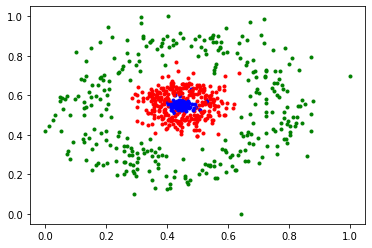

Model: "sequential_78"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_155 (Dense)            (None, 4)                 12        
_________________________________________________________________
dense_156 (Dense)            (None, 3)                 15        
Total params: 27
Trainable params: 27
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
900/900 [==============================] - 0s 310us/step - loss: 1.1372 - accuracy: 0.3333
Epoch 2/100
900/900 [==============================] - 0s 79us/step - loss: 1.1371 - accuracy: 0.3333
Epoch 3/100
900/900 [==============================] - 0s 79us/step - loss: 1.1369 - accuracy: 0.3333
Epoch 4/100
900/900 [==============================] - 0s 101us/step - loss: 1.1367 - accuracy: 0.3333
Epoch 5/100
900/900 [==============================] - 0s 79us/step - loss: 1.1366 - accuracy: 0.3333
Epoch 6

900/900 [==============================] - 0s 83us/step - loss: 1.1268 - accuracy: 0.3333
Epoch 75/100
900/900 [==============================] - 0s 80us/step - loss: 1.1267 - accuracy: 0.3333
Epoch 76/100
900/900 [==============================] - 0s 79us/step - loss: 1.1265 - accuracy: 0.3333
Epoch 77/100
900/900 [==============================] - 0s 79us/step - loss: 1.1264 - accuracy: 0.3333
Epoch 78/100
900/900 [==============================] - 0s 99us/step - loss: 1.1263 - accuracy: 0.3333
Epoch 79/100
900/900 [==============================] - 0s 78us/step - loss: 1.1262 - accuracy: 0.3333
Epoch 80/100
900/900 [==============================] - 0s 81us/step - loss: 1.1261 - accuracy: 0.3333
Epoch 81/100
900/900 [==============================] - 0s 80us/step - loss: 1.1260 - accuracy: 0.3333
Epoch 82/100
900/900 [==============================] - 0s 79us/step - loss: 1.1258 - accuracy: 0.3333
Epoch 83/100
900/900 [==============================] - 0s 79us/step - loss: 1.1257 - 

900/900 [==============================] - 0s 79us/step - loss: 1.1770 - accuracy: 0.3244
Epoch 48/100
900/900 [==============================] - 0s 78us/step - loss: 1.1766 - accuracy: 0.3244
Epoch 49/100
900/900 [==============================] - 0s 78us/step - loss: 1.1763 - accuracy: 0.3244
Epoch 50/100
900/900 [==============================] - 0s 78us/step - loss: 1.1760 - accuracy: 0.3244
Epoch 51/100
900/900 [==============================] - 0s 79us/step - loss: 1.1757 - accuracy: 0.3244
Epoch 52/100
900/900 [==============================] - 0s 78us/step - loss: 1.1754 - accuracy: 0.3244
Epoch 53/100
900/900 [==============================] - 0s 78us/step - loss: 1.1750 - accuracy: 0.3244
Epoch 54/100
900/900 [==============================] - 0s 78us/step - loss: 1.1747 - accuracy: 0.3244
Epoch 55/100
900/900 [==============================] - 0s 105us/step - loss: 1.1744 - accuracy: 0.3244
Epoch 56/100
900/900 [==============================] - 0s 82us/step - loss: 1.1741 -

900/900 [==============================] - 0s 108us/step - loss: 1.1038 - accuracy: 0.2033
Epoch 21/100
900/900 [==============================] - 0s 77us/step - loss: 1.1037 - accuracy: 0.2033
Epoch 22/100
900/900 [==============================] - 0s 77us/step - loss: 1.1037 - accuracy: 0.2033
Epoch 23/100
900/900 [==============================] - 0s 77us/step - loss: 1.1037 - accuracy: 0.2033
Epoch 24/100
900/900 [==============================] - 0s 100us/step - loss: 1.1037 - accuracy: 0.2033
Epoch 25/100
900/900 [==============================] - 0s 77us/step - loss: 1.1037 - accuracy: 0.2033
Epoch 26/100
900/900 [==============================] - 0s 77us/step - loss: 1.1036 - accuracy: 0.2033
Epoch 27/100
900/900 [==============================] - 0s 77us/step - loss: 1.1036 - accuracy: 0.2033
Epoch 28/100
900/900 [==============================] - 0s 77us/step - loss: 1.1036 - accuracy: 0.2033
Epoch 29/100
900/900 [==============================] - 0s 77us/step - loss: 1.1036 

900/900 [==============================] - 0s 128us/step - loss: 1.1024 - accuracy: 0.2044
Epoch 100/100
900/900 [==============================] - 0s 80us/step - loss: 1.1024 - accuracy: 0.2044
0.17
Model: "sequential_81"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_161 (Dense)            (None, 5)                 15        
_________________________________________________________________
dense_162 (Dense)            (None, 3)                 18        
Total params: 33
Trainable params: 33
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
900/900 [==============================] - 0s 288us/step - loss: 1.5119 - accuracy: 0.3422
Epoch 2/100
900/900 [==============================] - 0s 90us/step - loss: 1.5091 - accuracy: 0.3422
Epoch 3/100
900/900 [==============================] - 0s 91us/step - loss: 1.5064 - accuracy: 0.3422
Epoch 4/100


900/900 [==============================] - 0s 112us/step - loss: 1.3507 - accuracy: 0.3422
Epoch 73/100
900/900 [==============================] - 0s 83us/step - loss: 1.3489 - accuracy: 0.3422
Epoch 74/100
900/900 [==============================] - 0s 85us/step - loss: 1.3472 - accuracy: 0.3422
Epoch 75/100
900/900 [==============================] - 0s 85us/step - loss: 1.3454 - accuracy: 0.3422
Epoch 76/100
900/900 [==============================] - 0s 85us/step - loss: 1.3437 - accuracy: 0.3422
Epoch 77/100
900/900 [==============================] - 0s 85us/step - loss: 1.3419 - accuracy: 0.3422
Epoch 78/100
900/900 [==============================] - 0s 85us/step - loss: 1.3401 - accuracy: 0.3422
Epoch 79/100
900/900 [==============================] - 0s 85us/step - loss: 1.3383 - accuracy: 0.3422
Epoch 80/100
900/900 [==============================] - 0s 85us/step - loss: 1.3367 - accuracy: 0.3422
Epoch 81/100
900/900 [==============================] - 0s 85us/step - loss: 1.3350 -

900/900 [==============================] - 0s 120us/step - loss: 1.1297 - accuracy: 0.3411
Epoch 46/100
900/900 [==============================] - 0s 145us/step - loss: 1.1296 - accuracy: 0.3411
Epoch 47/100
900/900 [==============================] - 0s 143us/step - loss: 1.1294 - accuracy: 0.3411
Epoch 48/100
900/900 [==============================] - 0s 98us/step - loss: 1.1292 - accuracy: 0.3411
Epoch 49/100
900/900 [==============================] - 0s 182us/step - loss: 1.1291 - accuracy: 0.3411
Epoch 50/100
900/900 [==============================] - 0s 74us/step - loss: 1.1290 - accuracy: 0.3411
Epoch 51/100
900/900 [==============================] - 0s 72us/step - loss: 1.1288 - accuracy: 0.3411
Epoch 52/100
900/900 [==============================] - 0s 66us/step - loss: 1.1287 - accuracy: 0.3411
Epoch 53/100
900/900 [==============================] - 0s 83us/step - loss: 1.1285 - accuracy: 0.3411
Epoch 54/100
900/900 [==============================] - 0s 78us/step - loss: 1.128

900/900 [==============================] - 0s 82us/step - loss: 1.3690 - accuracy: 0.3244
Epoch 19/100
900/900 [==============================] - 0s 76us/step - loss: 1.3674 - accuracy: 0.3244
Epoch 20/100
900/900 [==============================] - 0s 77us/step - loss: 1.3657 - accuracy: 0.3244
Epoch 21/100
900/900 [==============================] - 0s 90us/step - loss: 1.3641 - accuracy: 0.3244
Epoch 22/100
900/900 [==============================] - 0s 79us/step - loss: 1.3625 - accuracy: 0.3244
Epoch 23/100
900/900 [==============================] - 0s 79us/step - loss: 1.3609 - accuracy: 0.3244
Epoch 24/100
900/900 [==============================] - 0s 81us/step - loss: 1.3594 - accuracy: 0.3244
Epoch 25/100
900/900 [==============================] - 0s 82us/step - loss: 1.3578 - accuracy: 0.3244
Epoch 26/100
900/900 [==============================] - 0s 103us/step - loss: 1.3563 - accuracy: 0.3244
Epoch 27/100
900/900 [==============================] - 0s 94us/step - loss: 1.3547 -

900/900 [==============================] - 0s 106us/step - loss: 1.2645 - accuracy: 0.3244
Epoch 98/100
900/900 [==============================] - 0s 167us/step - loss: 1.2634 - accuracy: 0.3244
Epoch 99/100
900/900 [==============================] - 0s 97us/step - loss: 1.2624 - accuracy: 0.3244
Epoch 100/100
900/900 [==============================] - 0s 88us/step - loss: 1.2614 - accuracy: 0.3244
0.31


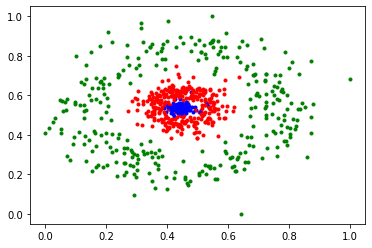

Model: "sequential_84"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_167 (Dense)            (None, 4)                 12        
_________________________________________________________________
dense_168 (Dense)            (None, 3)                 15        
Total params: 27
Trainable params: 27
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
900/900 [==============================] - 0s 318us/step - loss: 1.2669 - accuracy: 0.3389
Epoch 2/100
900/900 [==============================] - 0s 84us/step - loss: 1.2662 - accuracy: 0.3389
Epoch 3/100
900/900 [==============================] - 0s 83us/step - loss: 1.2656 - accuracy: 0.3389
Epoch 4/100
900/900 [==============================] - 0s 80us/step - loss: 1.2648 - accuracy: 0.3389
Epoch 5/100
900/900 [==============================] - 0s 79us/step - loss: 1.2641 - accuracy: 0.3389
Epoch 6/

900/900 [==============================] - 0s 108us/step - loss: 1.2235 - accuracy: 0.3389
Epoch 74/100
900/900 [==============================] - 0s 86us/step - loss: 1.2230 - accuracy: 0.3389
Epoch 75/100
900/900 [==============================] - 0s 78us/step - loss: 1.2225 - accuracy: 0.3389
Epoch 76/100
900/900 [==============================] - 0s 77us/step - loss: 1.2220 - accuracy: 0.3389
Epoch 77/100
900/900 [==============================] - 0s 77us/step - loss: 1.2215 - accuracy: 0.3389
Epoch 78/100
900/900 [==============================] - 0s 77us/step - loss: 1.2210 - accuracy: 0.3389
Epoch 79/100
900/900 [==============================] - 0s 94us/step - loss: 1.2205 - accuracy: 0.3389
Epoch 80/100
900/900 [==============================] - 0s 77us/step - loss: 1.2200 - accuracy: 0.3389
Epoch 81/100
900/900 [==============================] - 0s 77us/step - loss: 1.2196 - accuracy: 0.3389
Epoch 82/100
900/900 [==============================] - 0s 77us/step - loss: 1.2191 -

900/900 [==============================] - 0s 87us/step - loss: 1.1688 - accuracy: 0.3389
Epoch 47/100
900/900 [==============================] - 0s 115us/step - loss: 1.1685 - accuracy: 0.3389
Epoch 48/100
900/900 [==============================] - 0s 102us/step - loss: 1.1682 - accuracy: 0.3389
Epoch 49/100
900/900 [==============================] - 0s 110us/step - loss: 1.1679 - accuracy: 0.3389
Epoch 50/100
900/900 [==============================] - 0s 95us/step - loss: 1.1676 - accuracy: 0.3389
Epoch 51/100
900/900 [==============================] - 0s 83us/step - loss: 1.1674 - accuracy: 0.3389
Epoch 52/100
900/900 [==============================] - 0s 90us/step - loss: 1.1671 - accuracy: 0.3389
Epoch 53/100
900/900 [==============================] - 0s 145us/step - loss: 1.1668 - accuracy: 0.3389
Epoch 54/100
900/900 [==============================] - 0s 134us/step - loss: 1.1666 - accuracy: 0.3389
Epoch 55/100
900/900 [==============================] - 0s 81us/step - loss: 1.16

900/900 [==============================] - 0s 90us/step - loss: 1.1316 - accuracy: 0.2456
Epoch 20/100
900/900 [==============================] - 0s 86us/step - loss: 1.1314 - accuracy: 0.2456
Epoch 21/100
900/900 [==============================] - 0s 149us/step - loss: 1.1313 - accuracy: 0.2444
Epoch 22/100
900/900 [==============================] - 0s 142us/step - loss: 1.1311 - accuracy: 0.2444
Epoch 23/100
900/900 [==============================] - 0s 112us/step - loss: 1.1310 - accuracy: 0.2444
Epoch 24/100
900/900 [==============================] - 0s 100us/step - loss: 1.1308 - accuracy: 0.2433
Epoch 25/100
900/900 [==============================] - 0s 110us/step - loss: 1.1307 - accuracy: 0.2433
Epoch 26/100
900/900 [==============================] - 0s 104us/step - loss: 1.1305 - accuracy: 0.2422
Epoch 27/100
900/900 [==============================] - 0s 106us/step - loss: 1.1304 - accuracy: 0.2422
Epoch 28/100
900/900 [==============================] - 0s 90us/step - loss: 1.

900/900 [==============================] - 0s 162us/step - loss: 1.1220 - accuracy: 0.2222
Epoch 99/100
900/900 [==============================] - 0s 98us/step - loss: 1.1220 - accuracy: 0.2211
Epoch 100/100
900/900 [==============================] - 0s 170us/step - loss: 1.1219 - accuracy: 0.2189
0.29
Model: "sequential_87"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_173 (Dense)            (None, 5)                 15        
_________________________________________________________________
dense_174 (Dense)            (None, 3)                 18        
Total params: 33
Trainable params: 33
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
900/900 [==============================] - 0s 372us/step - loss: 1.1227 - accuracy: 0.3222
Epoch 2/100
900/900 [==============================] - 0s 79us/step - loss: 1.1226 - accuracy: 0.3222
Epoch 3/10

900/900 [==============================] - 0s 73us/step - loss: 1.1163 - accuracy: 0.3222
Epoch 72/100
900/900 [==============================] - 0s 80us/step - loss: 1.1162 - accuracy: 0.3222
Epoch 73/100
900/900 [==============================] - 0s 89us/step - loss: 1.1162 - accuracy: 0.3222
Epoch 74/100
900/900 [==============================] - 0s 89us/step - loss: 1.1161 - accuracy: 0.3222
Epoch 75/100
900/900 [==============================] - 0s 106us/step - loss: 1.1160 - accuracy: 0.3222
Epoch 76/100
900/900 [==============================] - 0s 145us/step - loss: 1.1160 - accuracy: 0.3222
Epoch 77/100
900/900 [==============================] - 0s 107us/step - loss: 1.1159 - accuracy: 0.3222
Epoch 78/100
900/900 [==============================] - 0s 104us/step - loss: 1.1158 - accuracy: 0.3222
Epoch 79/100
900/900 [==============================] - 0s 171us/step - loss: 1.1157 - accuracy: 0.3222
Epoch 80/100
900/900 [==============================] - 0s 123us/step - loss: 1.1

900/900 [==============================] - 0s 145us/step - loss: 1.1447 - accuracy: 0.3378
Epoch 45/100
900/900 [==============================] - 0s 117us/step - loss: 1.1445 - accuracy: 0.3378
Epoch 46/100
900/900 [==============================] - 0s 106us/step - loss: 1.1443 - accuracy: 0.3378
Epoch 47/100
900/900 [==============================] - 0s 85us/step - loss: 1.1441 - accuracy: 0.3378
Epoch 48/100
900/900 [==============================] - 0s 89us/step - loss: 1.1439 - accuracy: 0.3378
Epoch 49/100
900/900 [==============================] - 0s 89us/step - loss: 1.1437 - accuracy: 0.3378
Epoch 50/100
900/900 [==============================] - 0s 101us/step - loss: 1.1435 - accuracy: 0.3378
Epoch 51/100
900/900 [==============================] - 0s 93us/step - loss: 1.1433 - accuracy: 0.3378
Epoch 52/100
900/900 [==============================] - 0s 95us/step - loss: 1.1431 - accuracy: 0.3378
Epoch 53/100
900/900 [==============================] - 0s 152us/step - loss: 1.14

900/900 [==============================] - 0s 136us/step - loss: 1.1878 - accuracy: 0.3222
Epoch 18/100
900/900 [==============================] - 0s 134us/step - loss: 1.1873 - accuracy: 0.3222
Epoch 19/100
900/900 [==============================] - 0s 120us/step - loss: 1.1868 - accuracy: 0.3222
Epoch 20/100
900/900 [==============================] - 0s 135us/step - loss: 1.1863 - accuracy: 0.3222
Epoch 21/100
900/900 [==============================] - 0s 105us/step - loss: 1.1858 - accuracy: 0.3222
Epoch 22/100
900/900 [==============================] - 0s 90us/step - loss: 1.1852 - accuracy: 0.3222
Epoch 23/100
900/900 [==============================] - 0s 92us/step - loss: 1.1847 - accuracy: 0.3222
Epoch 24/100
900/900 [==============================] - 0s 155us/step - loss: 1.1842 - accuracy: 0.3222
Epoch 25/100
900/900 [==============================] - 0s 159us/step - loss: 1.1837 - accuracy: 0.3222
Epoch 26/100
900/900 [==============================] - 0s 103us/step - loss: 1

900/900 [==============================] - 0s 102us/step - loss: 1.1542 - accuracy: 0.3222
Epoch 97/100
900/900 [==============================] - 0s 88us/step - loss: 1.1539 - accuracy: 0.3222
Epoch 98/100
900/900 [==============================] - 0s 90us/step - loss: 1.1535 - accuracy: 0.3222
Epoch 99/100
900/900 [==============================] - 0s 90us/step - loss: 1.1532 - accuracy: 0.3222
Epoch 100/100
900/900 [==============================] - 0s 231us/step - loss: 1.1528 - accuracy: 0.3222
0.33


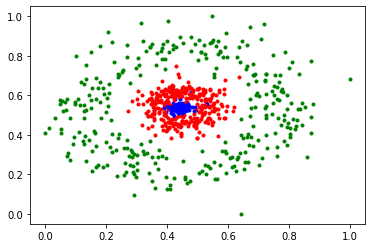

Model: "sequential_90"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_179 (Dense)            (None, 4)                 12        
_________________________________________________________________
dense_180 (Dense)            (None, 3)                 15        
Total params: 27
Trainable params: 27
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
900/900 [==============================] - 0s 329us/step - loss: 1.0987 - accuracy: 0.3333
Epoch 2/100
900/900 [==============================] - 0s 86us/step - loss: 1.0987 - accuracy: 0.3333
Epoch 3/100
900/900 [==============================] - 0s 104us/step - loss: 1.0987 - accuracy: 0.3333
Epoch 4/100
900/900 [==============================] - 0s 96us/step - loss: 1.0987 - accuracy: 0.3333
Epoch 5/100
900/900 [==============================] - 0s 85us/step - loss: 1.0987 - accuracy: 0.3333
Epoch 6

900/900 [==============================] - 0s 108us/step - loss: 1.0983 - accuracy: 0.3389
Epoch 75/100
900/900 [==============================] - 0s 79us/step - loss: 1.0983 - accuracy: 0.3389
Epoch 76/100
900/900 [==============================] - 0s 80us/step - loss: 1.0983 - accuracy: 0.3389
Epoch 77/100
900/900 [==============================] - 0s 79us/step - loss: 1.0982 - accuracy: 0.3389
Epoch 78/100
900/900 [==============================] - 0s 79us/step - loss: 1.0982 - accuracy: 0.3389
Epoch 79/100
900/900 [==============================] - 0s 79us/step - loss: 1.0982 - accuracy: 0.3400
Epoch 80/100
900/900 [==============================] - 0s 78us/step - loss: 1.0982 - accuracy: 0.3400
Epoch 81/100
900/900 [==============================] - 0s 79us/step - loss: 1.0982 - accuracy: 0.3400
Epoch 82/100
900/900 [==============================] - 0s 78us/step - loss: 1.0982 - accuracy: 0.3400
Epoch 83/100
900/900 [==============================] - 0s 78us/step - loss: 1.0982 -

900/900 [==============================] - 0s 58us/step - loss: 1.2073 - accuracy: 0.3256
Epoch 48/100
900/900 [==============================] - 0s 68us/step - loss: 1.2069 - accuracy: 0.3256
Epoch 49/100
900/900 [==============================] - 0s 58us/step - loss: 1.2063 - accuracy: 0.3256
Epoch 50/100
900/900 [==============================] - 0s 53us/step - loss: 1.2059 - accuracy: 0.3256
Epoch 51/100
900/900 [==============================] - 0s 38us/step - loss: 1.2054 - accuracy: 0.3256
Epoch 52/100
900/900 [==============================] - 0s 87us/step - loss: 1.2049 - accuracy: 0.3256
Epoch 53/100
900/900 [==============================] - 0s 129us/step - loss: 1.2044 - accuracy: 0.3256
Epoch 54/100
900/900 [==============================] - 0s 90us/step - loss: 1.2040 - accuracy: 0.3256
Epoch 55/100
900/900 [==============================] - 0s 90us/step - loss: 1.2035 - accuracy: 0.3256
Epoch 56/100
900/900 [==============================] - 0s 82us/step - loss: 1.2030 -

900/900 [==============================] - 0s 101us/step - loss: 1.0991 - accuracy: 0.4289
Epoch 21/100
900/900 [==============================] - 0s 83us/step - loss: 1.0991 - accuracy: 0.4289
Epoch 22/100
900/900 [==============================] - 0s 98us/step - loss: 1.0991 - accuracy: 0.4289
Epoch 23/100
900/900 [==============================] - 0s 76us/step - loss: 1.0991 - accuracy: 0.4289
Epoch 24/100
900/900 [==============================] - 0s 84us/step - loss: 1.0991 - accuracy: 0.4278
Epoch 25/100
900/900 [==============================] - 0s 86us/step - loss: 1.0991 - accuracy: 0.4278
Epoch 26/100
900/900 [==============================] - 0s 138us/step - loss: 1.0991 - accuracy: 0.4278
Epoch 27/100
900/900 [==============================] - 0s 77us/step - loss: 1.0991 - accuracy: 0.4278
Epoch 28/100
900/900 [==============================] - 0s 83us/step - loss: 1.0991 - accuracy: 0.4300
Epoch 29/100
900/900 [==============================] - 0s 80us/step - loss: 1.0990 

900/900 [==============================] - 0s 114us/step - loss: 1.0986 - accuracy: 0.4289
Epoch 100/100
900/900 [==============================] - 0s 108us/step - loss: 1.0986 - accuracy: 0.4289
0.47
Model: "sequential_93"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_185 (Dense)            (None, 5)                 15        
_________________________________________________________________
dense_186 (Dense)            (None, 3)                 18        
Total params: 33
Trainable params: 33
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
900/900 [==============================] - 0s 337us/step - loss: 1.5195 - accuracy: 0.3322
Epoch 2/100
900/900 [==============================] - 0s 78us/step - loss: 1.5176 - accuracy: 0.3322
Epoch 3/100
900/900 [==============================] - 0s 100us/step - loss: 1.5156 - accuracy: 0.3322
Epoch 4/10

900/900 [==============================] - 0s 97us/step - loss: 1.4034 - accuracy: 0.3322
Epoch 73/100
900/900 [==============================] - 0s 269us/step - loss: 1.4020 - accuracy: 0.3322
Epoch 74/100
900/900 [==============================] - 0s 135us/step - loss: 1.4007 - accuracy: 0.3322
Epoch 75/100
900/900 [==============================] - 0s 151us/step - loss: 1.3993 - accuracy: 0.3322
Epoch 76/100
900/900 [==============================] - 0s 87us/step - loss: 1.3979 - accuracy: 0.3322
Epoch 77/100
900/900 [==============================] - 0s 87us/step - loss: 1.3966 - accuracy: 0.3322
Epoch 78/100
900/900 [==============================] - 0s 113us/step - loss: 1.3953 - accuracy: 0.3322
Epoch 79/100
900/900 [==============================] - 0s 93us/step - loss: 1.3940 - accuracy: 0.3322
Epoch 80/100
900/900 [==============================] - 0s 92us/step - loss: 1.3926 - accuracy: 0.3322
Epoch 81/100
900/900 [==============================] - 0s 144us/step - loss: 1.39

900/900 [==============================] - 0s 172us/step - loss: 1.1042 - accuracy: 0.3278
Epoch 46/100
900/900 [==============================] - 0s 182us/step - loss: 1.1042 - accuracy: 0.3267
Epoch 47/100
900/900 [==============================] - 0s 165us/step - loss: 1.1042 - accuracy: 0.3267
Epoch 48/100
900/900 [==============================] - 0s 148us/step - loss: 1.1042 - accuracy: 0.3267
Epoch 49/100
900/900 [==============================] - 0s 241us/step - loss: 1.1042 - accuracy: 0.3267
Epoch 50/100
900/900 [==============================] - 0s 130us/step - loss: 1.1042 - accuracy: 0.3267
Epoch 51/100
900/900 [==============================] - 0s 119us/step - loss: 1.1041 - accuracy: 0.3267
Epoch 52/100
900/900 [==============================] - 0s 114us/step - loss: 1.1041 - accuracy: 0.3267
Epoch 53/100
900/900 [==============================] - 0s 111us/step - loss: 1.1041 - accuracy: 0.3267
Epoch 54/100
900/900 [==============================] - 0s 111us/step - loss:

900/900 [==============================] - 0s 138us/step - loss: 1.2173 - accuracy: 0.3422
Epoch 19/100
900/900 [==============================] - 0s 77us/step - loss: 1.2166 - accuracy: 0.3422
Epoch 20/100
900/900 [==============================] - 0s 92us/step - loss: 1.2160 - accuracy: 0.3422
Epoch 21/100
900/900 [==============================] - 0s 91us/step - loss: 1.2153 - accuracy: 0.3422
Epoch 22/100
900/900 [==============================] - 0s 121us/step - loss: 1.2147 - accuracy: 0.3422
Epoch 23/100
900/900 [==============================] - 0s 90us/step - loss: 1.2140 - accuracy: 0.3422
Epoch 24/100
900/900 [==============================] - 0s 97us/step - loss: 1.2134 - accuracy: 0.3422
Epoch 25/100
900/900 [==============================] - 0s 146us/step - loss: 1.2127 - accuracy: 0.34220s - loss: 1.2154 - accuracy: 0.34
Epoch 26/100
900/900 [==============================] - ETA: 0s - loss: 1.1830 - accuracy: 0.37 - 0s 131us/step - loss: 1.2121 - accuracy: 0.3422
Epoch 

900/900 [==============================] - 0s 91us/step - loss: 1.1756 - accuracy: 0.3422
Epoch 97/100
900/900 [==============================] - 0s 88us/step - loss: 1.1752 - accuracy: 0.3422
Epoch 98/100
900/900 [==============================] - 0s 91us/step - loss: 1.1748 - accuracy: 0.3422
Epoch 99/100
900/900 [==============================] - 0s 89us/step - loss: 1.1743 - accuracy: 0.3422
Epoch 100/100
900/900 [==============================] - 0s 224us/step - loss: 1.1739 - accuracy: 0.3422
0.31


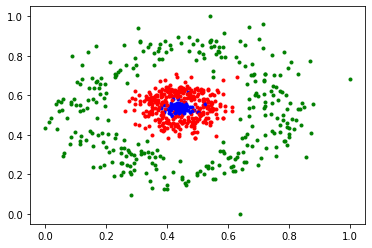

Model: "sequential_96"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_191 (Dense)            (None, 4)                 12        
_________________________________________________________________
dense_192 (Dense)            (None, 3)                 15        
Total params: 27
Trainable params: 27
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
900/900 [==============================] - 0s 353us/step - loss: 1.1185 - accuracy: 0.2078
Epoch 2/100
900/900 [==============================] - 0s 104us/step - loss: 1.1184 - accuracy: 0.2078
Epoch 3/100
900/900 [==============================] - 0s 102us/step - loss: 1.1183 - accuracy: 0.2111
Epoch 4/100
900/900 [==============================] - 0s 105us/step - loss: 1.1182 - accuracy: 0.2100
Epoch 5/100
900/900 [==============================] - 0s 106us/step - loss: 1.1180 - accuracy: 0.2100
Epoc

Epoch 74/100
900/900 [==============================] - 0s 231us/step - loss: 1.1125 - accuracy: 0.2456
Epoch 75/100
900/900 [==============================] - 0s 137us/step - loss: 1.1124 - accuracy: 0.2456
Epoch 76/100
900/900 [==============================] - 0s 105us/step - loss: 1.1123 - accuracy: 0.2478
Epoch 77/100
900/900 [==============================] - 0s 143us/step - loss: 1.1123 - accuracy: 0.2467
Epoch 78/100
900/900 [==============================] - 0s 107us/step - loss: 1.1122 - accuracy: 0.2489
Epoch 79/100
900/900 [==============================] - 0s 169us/step - loss: 1.1121 - accuracy: 0.2500
Epoch 80/100
900/900 [==============================] - 0s 89us/step - loss: 1.1121 - accuracy: 0.2478
Epoch 81/100
900/900 [==============================] - 0s 96us/step - loss: 1.1120 - accuracy: 0.2500
Epoch 82/100
900/900 [==============================] - 0s 118us/step - loss: 1.1119 - accuracy: 0.2544
Epoch 83/100
900/900 [==============================] - 0s 227us/s

900/900 [==============================] - 0s 114us/step - loss: 1.1258 - accuracy: 0.3456
Epoch 48/100
900/900 [==============================] - 0s 102us/step - loss: 1.1257 - accuracy: 0.3456
Epoch 49/100
900/900 [==============================] - 0s 106us/step - loss: 1.1256 - accuracy: 0.3456
Epoch 50/100
900/900 [==============================] - 0s 133us/step - loss: 1.1254 - accuracy: 0.3456
Epoch 51/100
900/900 [==============================] - 0s 85us/step - loss: 1.1253 - accuracy: 0.3456
Epoch 52/100
900/900 [==============================] - 0s 91us/step - loss: 1.1251 - accuracy: 0.3456
Epoch 53/100
900/900 [==============================] - 0s 96us/step - loss: 1.1250 - accuracy: 0.3456
Epoch 54/100
900/900 [==============================] - 0s 104us/step - loss: 1.1248 - accuracy: 0.3456
Epoch 55/100
900/900 [==============================] - 0s 93us/step - loss: 1.1247 - accuracy: 0.3456
Epoch 56/100
900/900 [==============================] - 0s 140us/step - loss: 1.1

900/900 [==============================] - 0s 178us/step - loss: 1.1401 - accuracy: 0.3456
Epoch 20/100
900/900 [==============================] - 0s 137us/step - loss: 1.1398 - accuracy: 0.3456
Epoch 21/100
900/900 [==============================] - 0s 118us/step - loss: 1.1395 - accuracy: 0.3456
Epoch 22/100
900/900 [==============================] - 0s 132us/step - loss: 1.1392 - accuracy: 0.3456
Epoch 23/100
900/900 [==============================] - 0s 124us/step - loss: 1.1389 - accuracy: 0.3456
Epoch 24/100
900/900 [==============================] - 0s 124us/step - loss: 1.1386 - accuracy: 0.3456
Epoch 25/100
900/900 [==============================] - 0s 117us/step - loss: 1.1383 - accuracy: 0.3456
Epoch 26/100
900/900 [==============================] - 0s 161us/step - loss: 1.1380 - accuracy: 0.3456
Epoch 27/100
900/900 [==============================] - 0s 145us/step - loss: 1.1377 - accuracy: 0.3456
Epoch 28/100
900/900 [==============================] - 0s 90us/step - loss: 

900/900 [==============================] - 0s 82us/step - loss: 1.1217 - accuracy: 0.3467
Epoch 98/100
900/900 [==============================] - 0s 94us/step - loss: 1.1215 - accuracy: 0.3467
Epoch 99/100
900/900 [==============================] - 0s 91us/step - loss: 1.1213 - accuracy: 0.3467
Epoch 100/100
900/900 [==============================] - 0s 92us/step - loss: 1.1211 - accuracy: 0.3467
0.31
Model: "sequential_99"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_197 (Dense)            (None, 5)                 15        
_________________________________________________________________
dense_198 (Dense)            (None, 3)                 18        
Total params: 33
Trainable params: 33
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
900/900 [==============================] - 0s 327us/step - loss: 1.3008 - accuracy: 0.3356
Epoch 2/100

900/900 [==============================] - 0s 125us/step - loss: 1.2331 - accuracy: 0.3356
Epoch 71/100
900/900 [==============================] - 0s 109us/step - loss: 1.2324 - accuracy: 0.3356
Epoch 72/100
900/900 [==============================] - 0s 167us/step - loss: 1.2316 - accuracy: 0.3356
Epoch 73/100
900/900 [==============================] - 0s 152us/step - loss: 1.2308 - accuracy: 0.3356
Epoch 74/100
900/900 [==============================] - 0s 112us/step - loss: 1.2300 - accuracy: 0.3356
Epoch 75/100
900/900 [==============================] - 0s 93us/step - loss: 1.2292 - accuracy: 0.3356
Epoch 76/100
900/900 [==============================] - 0s 89us/step - loss: 1.2285 - accuracy: 0.3356
Epoch 77/100
900/900 [==============================] - 0s 89us/step - loss: 1.2277 - accuracy: 0.3356
Epoch 78/100
900/900 [==============================] - 0s 104us/step - loss: 1.2269 - accuracy: 0.3356
Epoch 79/100
900/900 [==============================] - 0s 100us/step - loss: 1.

900/900 [==============================] - 0s 164us/step - loss: 1.1681 - accuracy: 0.4878
Epoch 44/100
900/900 [==============================] - 0s 142us/step - loss: 1.1676 - accuracy: 0.4878
Epoch 45/100
900/900 [==============================] - 0s 169us/step - loss: 1.1671 - accuracy: 0.4878
Epoch 46/100
900/900 [==============================] - 0s 171us/step - loss: 1.1667 - accuracy: 0.4878
Epoch 47/100
900/900 [==============================] - 0s 135us/step - loss: 1.1662 - accuracy: 0.4878
Epoch 48/100
900/900 [==============================] - 0s 111us/step - loss: 1.1658 - accuracy: 0.4878
Epoch 49/100
900/900 [==============================] - 0s 132us/step - loss: 1.1654 - accuracy: 0.4878
Epoch 50/100
900/900 [==============================] - 0s 131us/step - loss: 1.1649 - accuracy: 0.4878
Epoch 51/100
900/900 [==============================] - 0s 231us/step - loss: 1.1645 - accuracy: 0.4878
Epoch 52/100
900/900 [==============================] - 0s 182us/step - loss:

900/900 [==============================] - 0s 84us/step - loss: 1.2381 - accuracy: 0.3189
Epoch 17/100
900/900 [==============================] - 0s 86us/step - loss: 1.2374 - accuracy: 0.3189
Epoch 18/100
900/900 [==============================] - 0s 155us/step - loss: 1.2367 - accuracy: 0.3189
Epoch 19/100
900/900 [==============================] - 0s 106us/step - loss: 1.2361 - accuracy: 0.3189
Epoch 20/100
900/900 [==============================] - 0s 97us/step - loss: 1.2354 - accuracy: 0.3189
Epoch 21/100
900/900 [==============================] - 0s 80us/step - loss: 1.2347 - accuracy: 0.3189
Epoch 22/100
900/900 [==============================] - 0s 86us/step - loss: 1.2341 - accuracy: 0.3189
Epoch 23/100
900/900 [==============================] - 0s 114us/step - loss: 1.2334 - accuracy: 0.3189
Epoch 24/100
900/900 [==============================] - 0s 112us/step - loss: 1.2327 - accuracy: 0.3189
Epoch 25/100
900/900 [==============================] - 0s 90us/step - loss: 1.232

900/900 [==============================] - 0s 82us/step - loss: 1.1928 - accuracy: 0.3189
Epoch 96/100
900/900 [==============================] - 0s 81us/step - loss: 1.1923 - accuracy: 0.3189
Epoch 97/100
900/900 [==============================] - 0s 80us/step - loss: 1.1918 - accuracy: 0.3189
Epoch 98/100
900/900 [==============================] - 0s 81us/step - loss: 1.1913 - accuracy: 0.3189
Epoch 99/100
900/900 [==============================] - 0s 80us/step - loss: 1.1909 - accuracy: 0.3189
Epoch 100/100
900/900 [==============================] - 0s 81us/step - loss: 1.1904 - accuracy: 0.3189
0.36


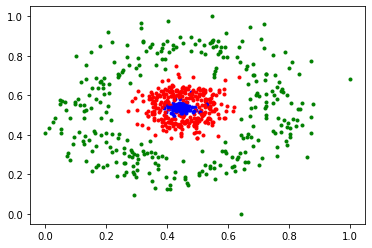

Model: "sequential_102"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_203 (Dense)            (None, 4)                 12        
_________________________________________________________________
dense_204 (Dense)            (None, 3)                 15        
Total params: 27
Trainable params: 27
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
900/900 [==============================] - 0s 320us/step - loss: 1.1208 - accuracy: 0.3311
Epoch 2/100
900/900 [==============================] - 0s 78us/step - loss: 1.1207 - accuracy: 0.3311
Epoch 3/100
900/900 [==============================] - 0s 80us/step - loss: 1.1206 - accuracy: 0.3311
Epoch 4/100
900/900 [==============================] - 0s 101us/step - loss: 1.1205 - accuracy: 0.3311
Epoch 5/100
900/900 [==============================] - 0s 97us/step - loss: 1.1204 - accuracy: 0.3311
Epoch 

900/900 [==============================] - 0s 118us/step - loss: 1.1146 - accuracy: 0.3311
Epoch 75/100
900/900 [==============================] - 0s 186us/step - loss: 1.1145 - accuracy: 0.3311
Epoch 76/100
900/900 [==============================] - 0s 151us/step - loss: 1.1145 - accuracy: 0.3311
Epoch 77/100
900/900 [==============================] - 0s 152us/step - loss: 1.1144 - accuracy: 0.3311
Epoch 78/100
900/900 [==============================] - 0s 115us/step - loss: 1.1143 - accuracy: 0.3311
Epoch 79/100
900/900 [==============================] - 0s 85us/step - loss: 1.1143 - accuracy: 0.3311
Epoch 80/100
900/900 [==============================] - 0s 84us/step - loss: 1.1142 - accuracy: 0.3311
Epoch 81/100
900/900 [==============================] - 0s 85us/step - loss: 1.1141 - accuracy: 0.3311
Epoch 82/100
900/900 [==============================] - 0s 84us/step - loss: 1.1141 - accuracy: 0.3311
Epoch 83/100
900/900 [==============================] - 0s 85us/step - loss: 1.11

900/900 [==============================] - 0s 100us/step - loss: 1.1127 - accuracy: 0.3422
Epoch 48/100
900/900 [==============================] - 0s 151us/step - loss: 1.1126 - accuracy: 0.3422
Epoch 49/100
900/900 [==============================] - 0s 122us/step - loss: 1.1126 - accuracy: 0.3422
Epoch 50/100
900/900 [==============================] - 0s 90us/step - loss: 1.1125 - accuracy: 0.3422
Epoch 51/100
900/900 [==============================] - 0s 102us/step - loss: 1.1125 - accuracy: 0.3422
Epoch 52/100
900/900 [==============================] - 0s 110us/step - loss: 1.1124 - accuracy: 0.3422
Epoch 53/100
900/900 [==============================] - 0s 121us/step - loss: 1.1123 - accuracy: 0.3422
Epoch 54/100
900/900 [==============================] - 0s 103us/step - loss: 1.1123 - accuracy: 0.3422
Epoch 55/100
900/900 [==============================] - 0s 112us/step - loss: 1.1122 - accuracy: 0.3422
Epoch 56/100
900/900 [==============================] - 0s 176us/step - loss: 

900/900 [==============================] - 0s 91us/step - loss: 1.1175 - accuracy: 0.3467
Epoch 21/100
900/900 [==============================] - 0s 89us/step - loss: 1.1174 - accuracy: 0.3467
Epoch 22/100
900/900 [==============================] - 0s 89us/step - loss: 1.1173 - accuracy: 0.3467
Epoch 23/100
900/900 [==============================] - 0s 89us/step - loss: 1.1173 - accuracy: 0.3467
Epoch 24/100
900/900 [==============================] - 0s 90us/step - loss: 1.1172 - accuracy: 0.3467
Epoch 25/100
900/900 [==============================] - 0s 89us/step - loss: 1.1171 - accuracy: 0.3467
Epoch 26/100
900/900 [==============================] - 0s 90us/step - loss: 1.1170 - accuracy: 0.3467
Epoch 27/100
900/900 [==============================] - 0s 128us/step - loss: 1.1169 - accuracy: 0.3467
Epoch 28/100
900/900 [==============================] - 0s 106us/step - loss: 1.1168 - accuracy: 0.3467
Epoch 29/100
900/900 [==============================] - 0s 87us/step - loss: 1.1167 

900/900 [==============================] - 0s 101us/step - loss: 1.1117 - accuracy: 0.3733
Epoch 100/100
900/900 [==============================] - 0s 94us/step - loss: 1.1116 - accuracy: 0.3733
0.44
Model: "sequential_105"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_209 (Dense)            (None, 5)                 15        
_________________________________________________________________
dense_210 (Dense)            (None, 3)                 18        
Total params: 33
Trainable params: 33
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
900/900 [==============================] - 0s 368us/step - loss: 1.3274 - accuracy: 0.3156
Epoch 2/100
900/900 [==============================] - 0s 139us/step - loss: 1.3267 - accuracy: 0.3144
Epoch 3/100
900/900 [==============================] - 0s 90us/step - loss: 1.3261 - accuracy: 0.3156
Epoch 4/10

900/900 [==============================] - 0s 92us/step - loss: 1.2834 - accuracy: 0.3233
Epoch 73/100
900/900 [==============================] - 0s 87us/step - loss: 1.2829 - accuracy: 0.3233
Epoch 74/100
900/900 [==============================] - 0s 87us/step - loss: 1.2823 - accuracy: 0.3233
Epoch 75/100
900/900 [==============================] - 0s 87us/step - loss: 1.2817 - accuracy: 0.3233
Epoch 76/100
900/900 [==============================] - 0s 92us/step - loss: 1.2811 - accuracy: 0.3233
Epoch 77/100
900/900 [==============================] - 0s 87us/step - loss: 1.2805 - accuracy: 0.3233
Epoch 78/100
900/900 [==============================] - 0s 87us/step - loss: 1.2799 - accuracy: 0.3244
Epoch 79/100
900/900 [==============================] - 0s 91us/step - loss: 1.2794 - accuracy: 0.3244
Epoch 80/100
900/900 [==============================] - 0s 89us/step - loss: 1.2788 - accuracy: 0.3256
Epoch 81/100
900/900 [==============================] - 0s 84us/step - loss: 1.2782 - 

900/900 [==============================] - 0s 119us/step - loss: 1.1195 - accuracy: 0.3278
Epoch 46/100
900/900 [==============================] - 0s 120us/step - loss: 1.1194 - accuracy: 0.3278
Epoch 47/100
900/900 [==============================] - 0s 105us/step - loss: 1.1193 - accuracy: 0.3278
Epoch 48/100
900/900 [==============================] - 0s 100us/step - loss: 1.1192 - accuracy: 0.3278
Epoch 49/100
900/900 [==============================] - 0s 83us/step - loss: 1.1191 - accuracy: 0.3278
Epoch 50/100
900/900 [==============================] - 0s 100us/step - loss: 1.1190 - accuracy: 0.3278
Epoch 51/100
900/900 [==============================] - 0s 87us/step - loss: 1.1189 - accuracy: 0.3278
Epoch 52/100
900/900 [==============================] - 0s 91us/step - loss: 1.1187 - accuracy: 0.3278
Epoch 53/100
900/900 [==============================] - 0s 111us/step - loss: 1.1186 - accuracy: 0.3278
Epoch 54/100
900/900 [==============================] - 0s 86us/step - loss: 1.1

900/900 [==============================] - 0s 154us/step - loss: 1.1117 - accuracy: 0.3267
Epoch 19/100
900/900 [==============================] - 0s 127us/step - loss: 1.1116 - accuracy: 0.3267
Epoch 20/100
900/900 [==============================] - 0s 97us/step - loss: 1.1116 - accuracy: 0.3267
Epoch 21/100
900/900 [==============================] - 0s 109us/step - loss: 1.1115 - accuracy: 0.3267
Epoch 22/100
900/900 [==============================] - 0s 157us/step - loss: 1.1115 - accuracy: 0.3267
Epoch 23/100
900/900 [==============================] - 0s 127us/step - loss: 1.1114 - accuracy: 0.3267
Epoch 24/100
900/900 [==============================] - 0s 113us/step - loss: 1.1113 - accuracy: 0.3267
Epoch 25/100
900/900 [==============================] - 0s 127us/step - loss: 1.1113 - accuracy: 0.3267
Epoch 26/100
900/900 [==============================] - 0s 146us/step - loss: 1.1112 - accuracy: 0.3267
Epoch 27/100
900/900 [==============================] - 0s 141us/step - loss: 

900/900 [==============================] - 0s 89us/step - loss: 1.1077 - accuracy: 0.3267
Epoch 98/100
900/900 [==============================] - 0s 113us/step - loss: 1.1077 - accuracy: 0.3267
Epoch 99/100
900/900 [==============================] - 0s 94us/step - loss: 1.1076 - accuracy: 0.3267
Epoch 100/100
900/900 [==============================] - 0s 84us/step - loss: 1.1076 - accuracy: 0.3267
0.29
[[0.    0.   ]
 [0.    0.   ]
 [0.    0.   ]
 [0.373 0.328]
 [0.343 0.348]
 [0.34  0.329]]
(4, 0)


NameError: name 'test_labels' is not defined

<Figure size 432x288 with 0 Axes>

In [107]:
n_error = True
while(n_error):
    try:
        test_labels = tenFoldCrossVal(dtrain1k_data, dtrain1k_labels)
        nPerceptrons = e_pair[0]
        af = e_pair[1]
        #test_score, test_labels = model(dtest_data.T, dtest_labels.T, af, nPerceptrons)
        #print(test_score)
        plt.figure()
        
        #test_labels = test_labels
       # print(test_labels)
        for i, xy in enumerate(dtest_data.T):
            if test_labels[i] == 1:
                plt.plot(xy[0], xy[1],'b.')
            if test_labels[i] == 2:
                plt.plot(xy[0], xy[1],'r.')
            if test_labels[i] == 3:
                plt.plot(xy[0], xy[1],'g.')
                
        plt.show()
        
        n_error = False
    except ZeroDivisionError:
        print('Reinitializing')
    except RuntimeError:
        print('Reinitializing')

In [ ]:
#n, e_pair = tenFoldCrossVal(dtrain500_data, dtrain500_labels)